In [74]:
from numpy import array
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score as get_r2_score, mean_absolute_error
from keras.utils.vis_utils import plot_model

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Mounted at /content/drive


In [5]:
downloaded = drive.CreateFile({'id':'15X31Q-RYIUfEKXkTeszOOfkICqQf8Zj4'}) 
downloaded.GetContentFile('ChicagoCrimeCountMonthly.csv')  
data = pd.read_csv('ChicagoCrimeCountMonthly.csv', error_bad_lines=False)

In [6]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data["Date"] = data["Date"].dt.strftime("%m/%d/%Y")
data

,Date,0
0,01/31/2001,74995
1,02/28/2001,66288
2,03/31/2001,53122
3,04/30/2001,40166
4,05/31/2001,41876
...,...,...
188,09/30/2016,23235
189,10/31/2016,23314
190,11/30/2016,21140
191,12/31/2016,19580


In [7]:
data.columns = ['Date', 'Crime Count']
crime_counts = np.asarray(data['Crime Count'].values)
print(len(crime_counts))
dates = np.asarray(data['Date'].values)
print(len(dates))

193
193


In [8]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

The CNN does not actually view the data as having time steps, instead, it is treated as a sequence over which convolutional read operations can be performed, like a one-dimensional image.

In [64]:
def fit_model(X, y, n_steps, n_features):
  # define model
  model = Sequential()
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_steps, 1)))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  print(model.summary())
  print(len(X), len(y))
  model.fit(X, y, epochs=1000, verbose=0)

  return model
 

In [10]:
def split_sequence(crime_counts, dates, n_steps):
  X, y, X_dates, y_date = list(), list(), list(), list()
  for i in range(len(crime_counts)):
    end_ix = i + n_steps
    if end_ix > len(crime_counts)-1:
      break
    seq_x, seq_y = crime_counts[i : end_ix], crime_counts[end_ix]
    seq_x_dates, seq_y_date = dates[i : end_ix], dates[end_ix]
    X.append(seq_x)
    y.append(seq_y)
    X_dates.append(seq_x_dates)
    y_date.append(seq_y_date)
  return array(X), array(y), array(X_dates), array(y_date)

In [38]:
def split_train_test_data(X, y, train_size, test_size, rolling_number):
  return X[rolling_number: train_size], X[train_size: train_size + test_size], y[rolling_number: train_size], y[train_size: train_size + test_size] 


In [13]:
def measure_error(actual, predicted):
  rmse = np.sqrt(mean_squared_error(actual, predicted))
  r2 = get_r2_score(actual, predicted)
  return rmse, r2 

In [67]:
def evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size):
  
  # defines how many time we want to insert into model to predict next timing
  n_steps = 40
  # split into samples
  X, y, X_dates, y_date = split_sequence(crime_counts, dates, n_steps)
  record_size = len(X)

  # reshape from [samples, timesteps] into [samples, timesteps, features]
  n_features = 1
  # print(X.shape[0], X.shape[1])
  X = X.reshape((X.shape[0], X.shape[1], n_features))
  X_dates = X_dates.reshape((X_dates.shape[0], X_dates.shape[1], n_features))
  rmse_scores = []
  r2_scores = []
  predictions = []
  y_test = []
  y_test_date = []
  model = None

  print("train_size", train_size, "test_size", test_size, "record_size", record_size)
  for i in range(train_size, record_size - test_size):
    rolling_number = i - train_size
    y_test = []
    y_test_date = []
    X_train, X_test, y_train, y_test= split_train_test_data(X , y, i, test_size, rolling_number)
    X_train_dates, X_test_dates, y_train_date, y_test_date = split_train_test_data(X_dates , y_date, i, test_size, rolling_number)

    model = fit_model(X_train, y_train, n_steps, n_features)
    print("Done Training The Data")

    predictions = []
    for i in range(0, len(X_test)):
      x_input = array(X_test[i])
      x_input = x_input.reshape((1, n_steps, n_features))
      yhat = model.predict(x_input, verbose=0)
      # print('Date', y_test_date[i])
      # print("Time Series Values", X_test[i])
      print("Predicted Crime Count", yhat[0][0], "Real Crime Count", y_test[i])
      predictions.append(yhat[0][0])
    print("Done Predicting The Data")
    rmse, r2 = measure_error(y_test, predictions)
    print(' RMSE: %.3f \t R2 score: %.3f' % (rmse, r2))
    rmse_scores.append(rmse)
    r2_scores.append(r2)
  return rmse_scores, r2_scores, model, predictions, y_test, y_test_date

In [81]:
def summarize(rmse_scores, r2_scores):
    rmse_scores = [i for i in rmse_scores]
    r2_scores = [i for i in r2_scores]
    rmse_mean, rmse_std = np.mean(rmse_scores), np.std(rmse_scores)
    r2_mean, r2_std = np.mean(r2_scores), np.std(r2_scores)
    print('RMSE: %.3f (+/- %.3f)' % (rmse_mean, rmse_std))
    print('R2: %.3f (+/- %.3f)' % (r2_mean, r2_std))
    plt.boxplot(rmse_scores)
    plt.show()
    plt.boxplot(r2_scores)
    plt.show()

In [77]:
train_size= 140
test_size = 12
rmse_scores, r2_scores, model, predictions, y_test, y_test_date = evaluation_on__rolling_forecasting(crime_counts, dates, train_size, test_size)

train_size 140 test_size 12 record_size 153
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 38, 256)           1024      
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 36, 256)           196864    
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 18, 256)           0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16, 256)           196864    
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 8, 256)            0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_57 

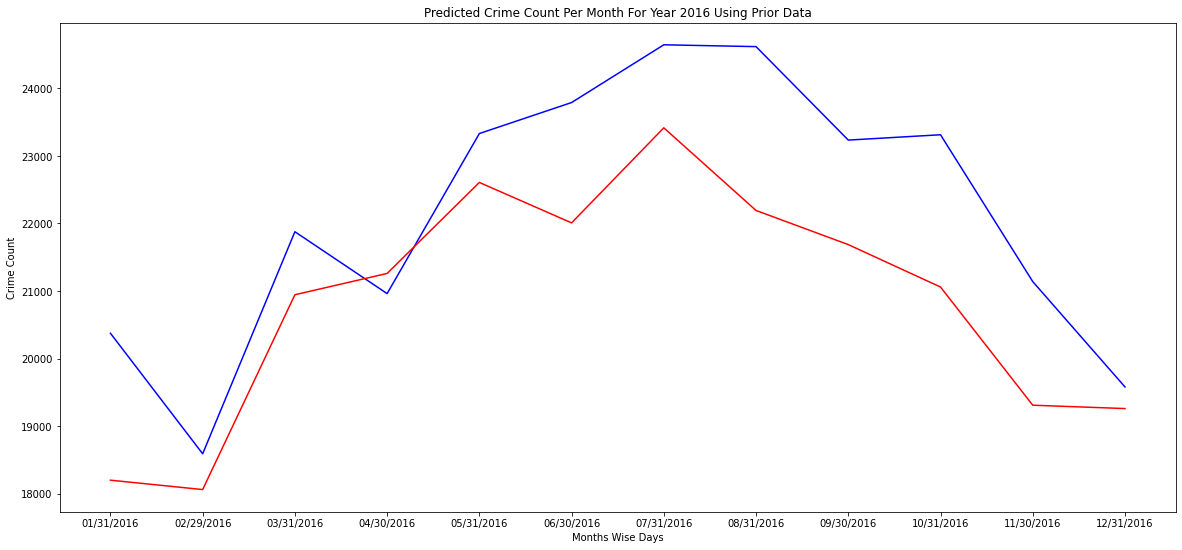

In [78]:
plt.figure(figsize=(20, 9))
plt.title('Predicted Crime Count Per Month For Year 2016 Using Prior Data')
plt.xlabel('Months Wise Days')
plt.ylabel('Crime Count')
plt.plot(y_test_date, y_test, color = 'blue')
plt.plot(y_test_date, predictions, color= 'red')
plt.show()

RMSE: 1527.658 (+/- 0.000)
R2: 0.362 (+/- 0.000)


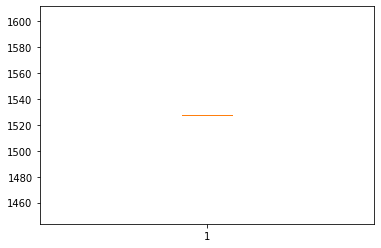

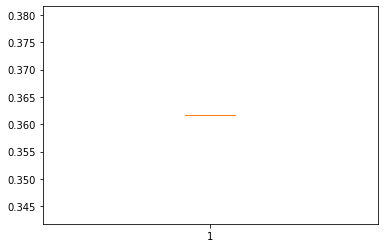

In [82]:
summarize(rmse_scores, r2_scores)

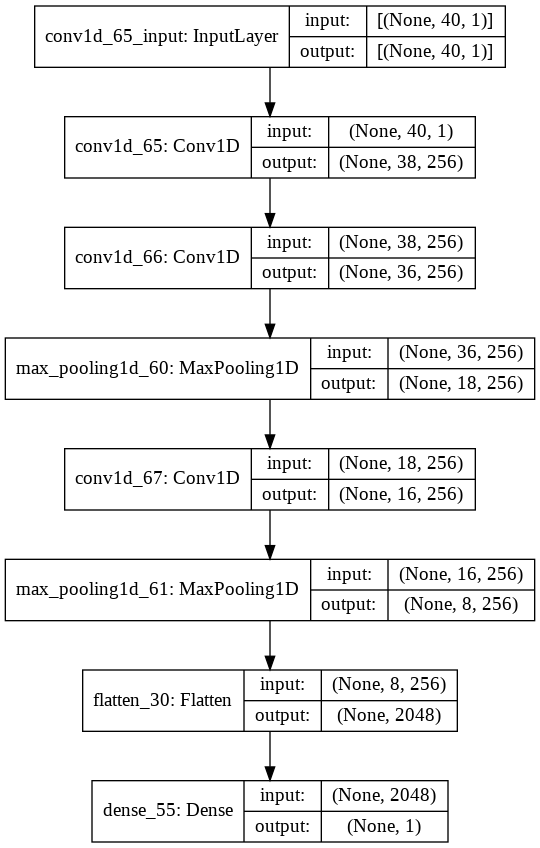

In [75]:
plot_model(model, to_file='mlp_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
y_test = np.asarray(y_test)
print(y_test)
predictions = np.asarray(predictions)
print(predictions)
mape = mean_absolute_error(y_test, predictions) * 100
mape

[20375 18590 21878 20962 23332 23791 24646 24619 23235 23314 21140 19580]
[19669.965 17935.102 17484.996 20808.088 21937.973 21202.744 23374.535
 21887.855 21815.348 20584.52  20566.486 20097.33 ]


159430.9895833333